In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import time

import re

import nltk 
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from bs4 import BeautifulSoup

import pickle

import tensorflow as tf

import tensorflow.keras as keras

from keras.models import Sequential

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Conv1D, MaxPooling1D, Bidirectional,Dropout

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
df=pd.read_csv("/content/drive/MyDrive/Colab Data files/IMDB Dataset.csv")

In [15]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

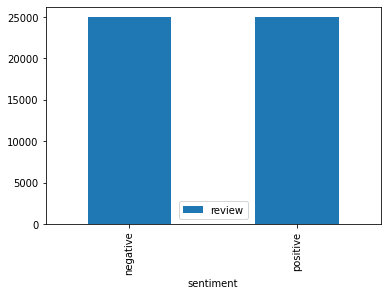

In [16]:
df.groupby('sentiment').count().plot(kind='bar')

In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [17]:
def preprocess(review):
    
    # convert to lowercase
    text = review.lower()
    #remove html text
    soup = BeautifulSoup(text, "html.parser")
    text= soup.get_text()
    # remove non letters special characters
    text = re.sub(r'[^a-zA-z0-9\s]', " ", text)
    #removing between square brackets
    text=re.sub('\[[^]]*\]', '', text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # stemming
    words = [PorterStemmer().stem(w) for w in words]
    #return list
    return words

In [18]:
df['review']=df['review'].apply(preprocess)

In [24]:
df['review'].head()

0    [one, review, mention, watch, 1, oz, episod, h...
1    [wonder, littl, product, film, techniqu, unass...
2    [thought, wonder, way, spend, time, hot, summe...
3    [basic, famili, littl, boy, jake, think, zombi...
4    [petter, mattei, love, time, money, visual, st...
Name: review, dtype: object

In [25]:
def tokenize_pad_sequences(text):
    # Text tokenization
    tokenizer = Tokenizer(num_words=15000, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=600)
    # return sequences
    return X, tokenizer

X, tokenizer = tokenize_pad_sequences(df['review'])

# saving
import pickle

with open('tokenizer_movies.pickle', 'wb') as tokenizer_movies:
    pickle.dump(tokenizer, tokenizer_movies, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
with open('tokenizer_movies.pickle', 'rb') as tokenizer_movies:
    tokenizer = pickle.load(tokenizer_movies)

In [27]:
Le = LabelEncoder()

Y = Le.fit_transform(df['sentiment'])
print(Le.classes_)

['negative' 'positive']


In [ ]:
X

array([[   3,  239,  358, ...,    0,    0,    0],
       [ 109,   53,  207, ...,    0,    0,    0],
       [  95,  109,   32, ...,    0,    0,    0],
       ...,
       [2749, 3644, 6462, ...,    0,    0,    0],
       [  25, 2404,  856, ...,    0,    0,    0],
       [   3,  150,   81, ...,    0,    0,    0]], dtype=int32)

In [28]:
model=keras.Sequential([keras.layers.Embedding(15000,16,input_length=600),
                        keras.layers.GlobalAveragePooling1D(),
                        keras.layers.Dense(16,activation='relu'),
                        keras.layers.Dense(2,activation='sigmoid')])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 16)           240000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 240,306
Trainable params: 240,306
Non-trainable params: 0
_________________________________________________________________


In [29]:
y=pd.get_dummies(df['sentiment'])
print(y.head())
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=1)

   negative  positive
0         0         1
1         0         1
2         0         1
3         1         0
4         0         1


In [30]:
model.fit(x_train,y_train,epochs=15,batch_size=120,validation_data=(x_val,y_val))

Epoch 1/15
250/250 [==============================] - 6s 17ms/step - loss: 0.6856 - accuracy: 0.5995 - val_loss: 0.6604 - val_accuracy: 0.7945
Epoch 2/15
250/250 [==============================] - 3s 12ms/step - loss: 0.5622 - accuracy: 0.8297 - val_loss: 0.4677 - val_accuracy: 0.8444
Epoch 3/15
250/250 [==============================] - 4s 15ms/step - loss: 0.3840 - accuracy: 0.8729 - val_loss: 0.3621 - val_accuracy: 0.8657
Epoch 4/15
250/250 [==============================] - 4s 17ms/step - loss: 0.2998 - accuracy: 0.8951 - val_loss: 0.3167 - val_accuracy: 0.8762
Epoch 5/15
250/250 [==============================] - 4s 17ms/step - loss: 0.2572 - accuracy: 0.9073 - val_loss: 0.2974 - val_accuracy: 0.8829
Epoch 6/15
250/250 [==============================] - 5s 18ms/step - loss: 0.2303 - accuracy: 0.9169 - val_loss: 0.2885 - val_accuracy: 0.8853
Epoch 7/15
250/250 [==============================] - 5s 18ms/step - loss: 0.2124 - accuracy: 0.9218 - val_loss: 0.2858 - val_accuracy: 0.8873

In [31]:
model.save('model_movies.h5')

In [32]:
from keras.models import load_model
model=load_model('model_movies.h5')
with open('tokenizer_movies.pickle', 'rb') as tokenizer_movies:
    tokenizer = pickle.load(tokenizer_movies)

In [33]:
def predict_class(text):
    
    sentiment_classes = ['Negative', 'Positive']
    max_len=600

    #text=preprocess(text)
    xt = tokenizer.texts_to_sequences(text)

    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)

    return sentiment_classes[yt[0]]

In [35]:
data="I love this movie"
print(data)
#preprocessing data which puts the words as seperate string 
#and then joining thw words by space and forming single string
#finally enclosing it within a list
data=[" ".join(preprocess(data))]
print(data)
predict_class(data)

I love this movie
['love movi']


'Positive'

In [36]:
model.evaluate(X_test,Y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2879 - accuracy: 0.8963


[0.2878560423851013, 0.8963000178337097]